In [1]:
# imports
import numpy as np
from numpy.linalg import norm
import pandas as pd
import requests
from bs4 import BeautifulSoup
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import multidict as multidict
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import re
from gensim.models import Word2Vec
from gensim.models import FastText

# SMA: Task I
## Exercise 1: Web Scraping (25 points)


In [2]:
def articles_of_date_to_df(date: str):
    ''' Grabs all the links of articles on the archive page of tagesschau.de for a given date.
        Then calls the 'article_to_dict' function for every link found.

    Args:
        date (string): Takes a date formatted as 'YYYY-MM-DD'.

    Returns:
        dataframe: Containing all desired elements for each article in a single row.
    '''

    def article_to_dict(url):
        ''' Takes an URL from https://www.tagesschau.de/ and returns a dictionary with the elements:
            'Title': title,
            'Date': metatextline,
            'Short Description': short_description,
            'Text': article_text,
            'Tags': tag_list

        Args:
            url (string): URL fo Article from https://www.tagesschau.de/

        Returns:
            dict: object called 'article_dict'
        '''

        # configuring BeautifulSoup
        soup = BeautifulSoup(requests.get(url).text, 'html.parser')

        # grabbing the title
        title = soup.select('span.seitenkopf__headline--text')[0].text

        # grabbing the date and time
        metatextline = soup.select('div.metatextline')[0].text

        # Remove first 28 characters
        metatextline = metatextline.replace(metatextline[0 : 28], '', 1)

        # Remove last 27 characters in string
        metatextline = ''.join(metatextline.rsplit(metatextline[-27:], 1))

        # designating paragraph paths
        all_paragraphs = soup.select('p.m-ten')

        # first instance of p.m-ten on page is always short description (bold text)
        short_description = all_paragraphs[0].text
        # removing \n tags from short_description
        short_description = short_description.replace('\n', '')
        
        # selecting all but the first paragraph
        paragraphs = all_paragraphs[1:]

        # iterating through each paragraph and joining them
        article_text = ' '.join([paragraph.text for paragraph in paragraphs])

        # text tidying
        # removing \n tags from text
        article_text = article_text.replace('\n', '')

        # removing \xa0 tags from text
        article_text = article_text.replace('\xa0', ' ')
        
        # removing double and triple spaces
        article_text = article_text.replace('   ', ' ')
        article_text = article_text.replace('  ', ' ')

        # picking up tags
        tags = soup.select('a.tag-btn')
        tag_list = ', '.join([tag.text for tag in tags])

        # writing elements to dict
        article_dict = {
        'Title': title,
        'Date': metatextline,
        'Short_Description': short_description,
        'Text': article_text,
        'Tags': tag_list}

        return article_dict

    # first part of url
    link = 'https://www.tagesschau.de/archiv/?datum='
    
    # combining link and date to form the correct url
    url = ''.join([link, date])
    
    # storing request response in r
    r = requests.get(url)

    # parsing request response content
    soup = BeautifulSoup(r.content)

    # initializing list to store article urls
    article_urls = []
    # plucking all article url from the soup 
    for a_tag in soup.find_all('a', class_='teaser-xs__link', href=True):
        # appending article urls to list
        article_urls.append(a_tag['href'])

    # initializing list to store dicts with article information
    list_of_dicts = []
    # applying article_to_dict function to each article url
    for url in article_urls:
        # then append the result to list_of_dicts
        list_of_dicts.append(article_to_dict(url))
    
    # form df from list of dicts
    df = pd.DataFrame.from_dict(list_of_dicts)
    
    # reordering columns
    df = df[['Title', 'Date', 'Short_Description', 'Text', 'Tags']]
    
    # returning df
    return df

In [3]:
# demonstrating function for ‘2022-11-01’
articles = articles_of_date_to_df('2022-11-01')

In [4]:
# printing shape of articles table
articles.shape

(54, 5)

In [5]:
# showing first five rows of results
articles.head(5)

,Title,Date,Short_Description,Text,Tags
0,"Bolsonaro will ""Verfassung respektieren""",01.11.2022,Erstmals hat sich Brasiliens abgewählter Präsi...,Zwei Tage nach seiner Niederlage bei der Wahl ...,"Brasilien, Bolsonaro, Wahlergebnisse"
1,Starke Jobdaten belasten Wall Street,01.11.2022,Starke Daten vom US-Arbeitsmarkt ließen die Ku...,"Der Dow Jones schloss 0,24 Prozent tiefer auf ...","Marktbericht, Börse, DAX, Dow Jones, Geldanlag..."
2,Keiner der beiden Blöcke hat Mehrheit,01.11.2022,Nach der Parlamentswahl in Dänemark zeichent s...,Bei der Parlamentswahl in Dänemark hat ersten ...,Dänemark
3,Wahl in Israel: Netanyahus Bündnis laut Progno...,01.11.2022,Das Bündnis von Ex-Regierungschef Netanyahu li...,Weitere Informationen in Kürze.,Eilmeldung
4,Ist das Rennen schon gelaufen?,01.11.2022,Die Republikaner rechnen fest mit einem Erfolg...,"Die Republikaner haben gute Laune. ""Das ist un...","USA, Midterms, Republikaner"


## Exercise 2: Word Cloud (25 points)

In [6]:
def wordcloud(id: int, type: str, width=7.5, height=5.5):
    '''Makes one of two types of word clouds for a given article and type.

    Args:
        id (int): Article to create word cloud from
        type (str): Type of word cloud to be created ('noun' or 'entity')
        width (int): Width in inches
        height (int): Height in inches

    Returns:
        word cloud: For given article and type
    '''
    
    # importing tageschau article data
    df = pd.read_json('data/tagesschau_articles.json')
    
    # load spacy
    nlp = spacy.load('de_core_news_md')
    
    # load WordCloud
    wc = WordCloud()
    
    # load data
    df = pd.read_json('data/tagesschau_articles.json')
    
    # assign pandas series corrosponding to article of id to variable
    text = df[df.id == id].text
    
    # selecting only text from series
    text = text.iloc[0]
    
    # frequency counter
    # code example from https://www.tutorialspoint.com/count-frequencies-of-all-elements-in-array-in-python
    def freq_counter(words_to_count: list):
        '''Counts word frequencies in a given list.

        Args:
            words_to_count (list): List of words to be counted

        Returns:
            dict: Returns a dictonary with each word and its frequency
        '''
        
        # initializing dict to store frequency of each element
        elements_count = {}
        # iterating over the elements for frequency
        for element in words_to_count:
            # checking whether it is in the dict or not
            if element in elements_count:
                # incerementing the count by 1
                elements_count[element] += 1
            else:
                # setting the count to 1
                elements_count[element] = 1
        
        # initializing dict to store frequencies
        freqs = {}
        # filling dictionary with frequencies per word
        for key, value in elements_count.items():
            freqs[key] = value
        
        return freqs

    # if case 'noun'
    if type == 'noun':
        # intializing list for nouns
        nouns = []
        # adding word to list nouns if it is a noun
        for token in nlp(text):
            if token.pos_ in ['NOUN']:
                nouns.append(token.text)

        # creating word cloud 
        wc.generate_from_frequencies(freq_counter(nouns))
        plt.figure(figsize = (width, height))
        # plotting the word cloud
        fig = plt.imshow(wc)
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
        # return word cloud type nouns
        return fig

    # if case 'entities'
    if type == 'entities':
        # intializing the list
        entities = []
        # adding word to list if it is an entity
        for ent in nlp(text).ents:
            entities.append(ent.text)
        
        # creating word cloud 
        wc.generate_from_frequencies(freq_counter(entities))
        plt.figure(figsize = (width, height))
        # plotting the word cloud
        fig = plt.imshow(wc)
        plt.axis('off')

        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        # return word cloud type entities
        return fig

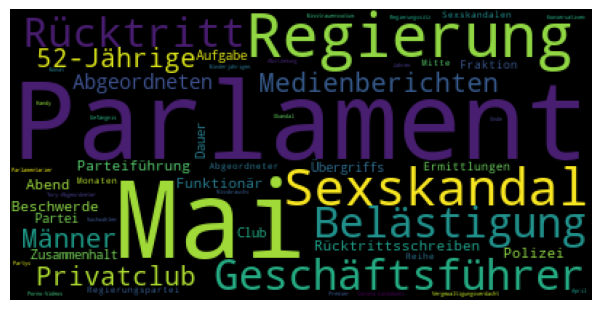

In [7]:
wordcloud(id=11, type='noun')

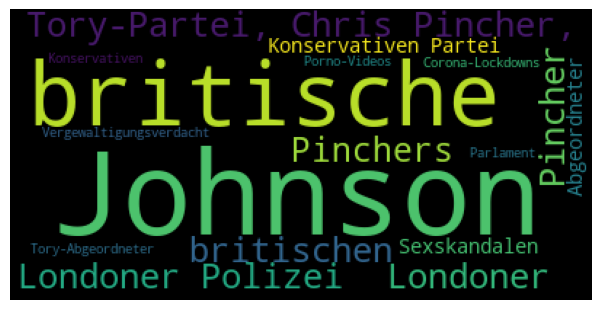

In [8]:
wordcloud(id=11, type='entities')

## Exercise 3: Train word embeddings (25 points)

In [9]:
# importing data
df = pd.read_json('data/tagesschau_articles.json')

In [10]:
# function to tokenize and clean article texts
def cleaner(row):
    # tokenize each row
    sents_in_row = sent_tokenize(row)
    
    # list for cleaned sentences
    l_sents_cleaned = []
    for sentence in sents_in_row:
        # character cleaning for each sentence in that row
        l_sents_cleaned.append(re.sub('[^A-Za-z0-9äöüÄÖÜßø]', ' ', sentence))

    # list for cleaned and tokenized sentences
    l_sents_cleaned_tokenized = []
    for sentence in l_sents_cleaned:
        # tokenizing each sentence
        tokens = word_tokenize(sentence)
        # appending each token as lowercase to tokens_in_sentence if that token is not a stop word
        l_sents_cleaned_tokenized.append([token.lower() for token in tokens if token not in stop_words])
    
    return l_sents_cleaned_tokenized

In [11]:
# generate column from tagline and overview columns
df['fulltext'] = df.title + ' ' + df.description + ' ' + df.text

# german stop words
stop_words = nltk.corpus.stopwords.words('german')

# applying cleaner function to column full text
df['cleaned'] = df.fulltext.apply(cleaner)

# creating corpus
corpus = []
for row in df.cleaned:
    for sentence in row:
        corpus.append(sentence)

In [12]:
# settings for Word2Vec and FastText
sentences=corpus
vector_size=80
window=6
min_count=6
epochs=100

# adapt for local machine if neccessary
workers=16
max_vocab_size=None

In [13]:
# training model and saving the word2vec model
Word2Vec(
    sentences=sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    epochs=epochs,
    workers=workers,
    max_vocab_size=max_vocab_size).save('models/word2vec')

In [14]:
# training model and saving the fasttext model
FastText(
    sentences=sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    epochs=epochs,
    workers=workers,
    max_vocab_size=max_vocab_size).save('models/fasttext')

## Exercise 4: Analyse and apply word embeddings (25 points)

### What are the 10 most similar words to “König”

In [15]:
# loading models into their variables
word2vec = Word2Vec.load('models/word2vec')
fasttext = FastText.load('models/fasttext')

In [16]:
# function to compare word similarities per model
def ten_most_similar_words_to(word: str):
    return pd.concat([
        pd.DataFrame(word2vec.wv.most_similar(word.lower(), topn=10), columns=['word', 'similarity']),
        pd.DataFrame(fasttext.wv.most_similar(word.lower(), topn=10), columns=['word', 'similarity'])],
        axis=1, keys=['word2vec','fasttext'])

In [17]:
ten_most_similar_words_to('König')

word2vec                   fasttext           
                word similarity            word similarity
0          monarchen   0.596059          königs   0.898767
1            charles   0.594668          könige   0.880168
2                iii   0.582441  königsgemahlin   0.845384
3          monarchin   0.569868    königsklasse   0.828646
4        thronfolger   0.568583      königshaus   0.779102
5            königin   0.566480         königin   0.763085
6  premierministerin   0.562048   königsfamilie   0.737796
7       verstorbenen   0.558767         monarch   0.726734
8              thron   0.541978      königliche   0.689887
9         buckingham   0.534337    königshauses   0.664496

## Carry out the same type of comparison for two or more other words of your choice.

In [18]:
ten_most_similar_words_to('Politik')

word2vec                             fasttext           
                   word similarity                      word similarity
0    gesellschaftlichen   0.503243                 politikum   0.902283
1     zivilgesellschaft   0.501471                  politico   0.822708
2          gesellschaft   0.489589             finanzpolitik   0.775342
3               haltung   0.473847              außenpolitik   0.772431
4             regierung   0.467293        wirtschaftspolitik   0.761500
5  widerstandsfähigkeit   0.464471             sozialpolitik   0.747469
6            opposition   0.463355              klimapolitik   0.744665
7             koalition   0.453855  politikwissenschaftlerin   0.735057
8            wirtschaft   0.448536             steuerpolitik   0.733746
9             strategie   0.448039                 politisch   0.727905

In [19]:
ten_most_similar_words_to('Korruption')

word2vec                          fasttext           
                word similarity                   word similarity
0       kriminalität   0.560599            korruptions   0.913916
1  vetternwirtschaft   0.490038                korrupt   0.908964
2       grassierende   0.467776               korrupte   0.852789
3        politischer   0.453579  korruptionsbekämpfung   0.827482
4  oppositionspartei   0.450889    korruptionsvorwürfe   0.822422
5         ausbeutung   0.447226          kollaboration   0.657094
6          wahlkampf   0.440880        diskriminierung   0.639270
7     streitigkeiten   0.437066              vorgehens   0.592473
8     globalisierung   0.434846             geldwäsche   0.586766
9        belästigung   0.431434               missouri   0.578472

In [20]:
ten_most_similar_words_to('Nachrichten')

word2vec                         fasttext           
            word similarity                  word similarity
0       konzerte   0.471417       chatnachrichten   0.913585
1      nachricht   0.467494       textnachrichten   0.902578
2        zalando   0.461795      nachrichtenseite   0.816862
3         videos   0.460583     falschnachrichten   0.792477
4          laune   0.448732             nachricht   0.781341
5         serien   0.435221    nachrichtensendung   0.772648
6  niederschläge   0.432337     nachrichtensender   0.769587
7       stimmung   0.420510      nachrichtenkanal   0.766992
8        ausgabe   0.415881     nachrichtenportal   0.752961
9     abonnenten   0.409815  nachrichtenagenturen   0.732984

In [21]:
ten_most_similar_words_to('Winter')

word2vec                   fasttext           
             word similarity            word similarity
0          herbst   0.625349     winterwelle   0.838317
1   gasmangellage   0.547631         winters   0.830392
2     heizperiode   0.547215   wintermonaten   0.758851
3          sommer   0.503951     wintershall   0.706727
4      gasnotlage   0.493282  winterhalbjahr   0.683886
5      gasvorräte   0.491498          gassen   0.610657
6         winters   0.480652   gasmangellage   0.606026
7   wintermonaten   0.479959       gasmangel   0.605982
8    gasheizungen   0.479621       eventuell   0.600445
9  verdreifachung   0.478807     eventuellen   0.598164

In [22]:
ten_most_similar_words_to('Woche')

word2vec                  fasttext           
        word similarity           word similarity
0     monats   0.688125      wochentag   0.795930
1      tagen   0.678336  sitzungswoche   0.784174
2     wochen   0.650282         wochen   0.775968
3     jahres   0.644463          tagen   0.742391
4      monat   0.643423         monats   0.721508
5   dienstag   0.628684    wochenstart   0.714699
6       jahr   0.621540    wochenmitte   0.699346
7      tages   0.603365     wochenende   0.692111
8   mittwoch   0.590985    börsenwoche   0.689225
9  september   0.583785          monat   0.683723

In [23]:
ten_most_similar_words_to('Monat')

word2vec                 fasttext           
          word similarity          word similarity
0         jahr   0.771576          jahr   0.808959
1        woche   0.643423    monatsende   0.758774
2       jahres   0.616650        monate   0.733848
3      monaten   0.599328       monaten   0.732183
4  vierteljahr   0.578315        monats   0.726407
5       wochen   0.576313     monatlich   0.723779
6        tagen   0.575173   jahresfrist   0.708499
7     frühjahr   0.573671  monatsbeginn   0.702568
8       jahren   0.543988   vierteljahr   0.683924
9       monate   0.515014         woche   0.683723

In [24]:
ten_most_similar_words_to('Jahr')

word2vec                 fasttext           
          word similarity          word similarity
0        monat   0.771576         monat   0.808959
1       jahres   0.671695     jahrgänge   0.790618
2     frühjahr   0.649701   vierteljahr   0.769727
3        woche   0.621540    jahresziel   0.768274
4  vierteljahr   0.612367        jahres   0.764525
5      monaten   0.600649      frühjahr   0.747318
6     halbjahr   0.585448     schuljahr   0.745716
7       sommer   0.584322    rekordjahr   0.741787
8        jahre   0.570162  jahreshälfte   0.738742
9       jahren   0.568680    jahreszeit   0.737306

In [25]:
ten_most_similar_words_to('Auto')

word2vec               fasttext           
         word similarity        word similarity
0       autos   0.592610       autos   0.745146
1    fahrzeug   0.527898   autofahrt   0.698065
2     fahrrad   0.523863     autonom   0.606795
3       bikes   0.522922     fahrrad   0.604860
4     rezepte   0.521206    fahrzeug   0.593702
5       wagen   0.507019   automobil   0.578421
6  zigaretten   0.486504      autors   0.574247
7     studium   0.483192  autofahrer   0.570963
8      roller   0.478501    autonome   0.570726
9     pendler   0.472324    autobahn   0.564620

### Provide at least one example, where you consider word2vec’s recommendations better, and one example where you prefer fastText’s recommendation.

**word2vec:** Politik, Korruption, Nachrichten, Winter

**fasttext:** Woche, Monat, Jahr

### Describe differences of the results

*Explain your findings by relating them to the conceptual differences/communalities of word2vec and fastText. Based on this small-scale analysis, which of the two models would you prefer for downstream machine learning tasks. Justify your answer.*

Word2vec represents words as a single vector, while fastText represents words as the sum of the vectors for their character n-grams.

It seems as if Word2Vec finds words which are close to the original word by association, the word 'King' for example is similar to 'Monarch' or 'Primeminister' by association of a position of power.

While fasttext mechanics seem to be based more strongly on the lemma or stem of the original word. The most similar words to 'König' according to fast text are 'Königs' und 'Könige'. This works in our favour with words describing time spans like: 'Woche', 'Monat' and 'Jahr'.

I expect this sort of behaviour to be reflected in the recommendations made by each model. Let's take the word 'Auto' for example, word2vec returns words like: 'fahrzeug', 'tankstelle' and 'bikes' while fasttext returns: 'autos', 'autofahrt' and 'autonom'. 

While there are many details to consider like the diversity of topics and overall size of dataset, I expect word2vec to return more interesting results rather than results with more of the same. This is particularly based on the results of: 'Winter'. Where the similarities to words associated with heating and gas are higher than fasttext results. 

## Create a recommender

*Create a content-based recommender for Tagesschau articles. Specifically, write a recommend function that takes the id of an article as an input, and returns the 5 most similar articles (you may return the five rows from the original DataFrame). Use your preferred embedding model from above to compute the article similarities. Demonstrate that your function works using recommend(id=11).*

In [26]:
# word2vec version
def recommend(id: int):
    word2vec = Word2Vec.load('models/word2vec')
    df = pd.read_json('data/tagesschau_articles.json')

    df['fulltext'] = df.title + ' ' + df.description + ' ' + df.text

    # german stop words
    stop_words = nltk.corpus.stopwords.words('german')

    # function to tokenize each article
    def row_cleaner(row):
        # tokenize each row
        sents_in_row = sent_tokenize(row)
        # list for cleaned sentences
        l_sents_cleaned = []
        for sentence in sents_in_row:
            # character cleaning for each sentence in that row
            l_sents_cleaned.append(re.sub('[^A-Za-z0-9äöüÄÖÜßø]', ' ', sentence))

        # list for cleaned and tokenized sentences
        l_sents_cleaned_tokenized = []
        for sentence in l_sents_cleaned:
            # tokenizing each sentence
            tokens = word_tokenize(sentence)
            # appending each token as lowercase to tokens_in_sentence if that token is not a stop word
            # l_sents_cleaned_tokenized.append([token.lower() for token in tokens if token not in stop_words])
            l_sents_cleaned_tokenized.append([token.lower() for token in tokens if token not in stop_words])
            flat_list = [item for sublist in l_sents_cleaned_tokenized for item in sublist]
        
        return flat_list

    # applying row_cleaner
    df['cleaned_row'] = df.fulltext.apply(row_cleaner)
    
    # function to calculate cosine similarity
    def cosine_similarity(x, y):
        return np.dot(x, y) / (norm(x) * norm(y))

    def w2v_get_mean_vector(row):
        return word2vec.wv.get_mean_vector(row)

    df['w2v_mean_vector'] = df.cleaned_row.apply(w2v_get_mean_vector)

    # assinging new variable for better readability
    reference_id = id
    
    # getting index/row number for given id
    row_number = df[df.id == reference_id].index.values[0]
    
    # assinging reference vector via row number
    reference_vector = df.w2v_mean_vector[row_number]

    sims = []
    for vector_b in df.w2v_mean_vector:
        sims.append(cosine_similarity(reference_vector, vector_b))
    df['w2v_similarity_to_reference'] = sims

    return df.sort_values('w2v_similarity_to_reference', ascending=False)[1:6]

In [27]:
# demonstrating function works
recommend(id=11)

,id,date,title,text,category,subcategory,description,tags,url,fulltext,cleaned_row,w2v_mean_vector,w2v_similarity_to_reference
204,206,2022-07-06,Regierungskrise in London: Minister erhöhen Dr...,Der britische Premier Boris Johnson verliert i...,ausland,europa,Der Druck auf den britischen Premier Johnson s...,"[Großbritannien, Boris Johnson]",https://www.tagesschau.de/ausland/europa/reakt...,Regierungskrise in London: Minister erhöhen Dr...,"[regierungskrise, london, minister, erhöhen, d...","[0.02152533, -0.0022534004, -0.005209878, -0.0...",0.908338
144,146,2022-07-05,Finanz- und Gesundheitsminister gehen: Rücktri...,Aus Protest gegen die Amtsführung des britisch...,ausland,europa,Der britische Premier Johnson hat zwei wichtig...,"[Großbritannien, Boris Johnson, Rishi Sunak, S...",https://www.tagesschau.de/ausland/europa/gross...,Finanz- und Gesundheitsminister gehen: Rücktri...,"[finanz, gesundheitsminister, gehen, rücktritt...","[0.024703246, 0.0011579577, -0.008544477, -0.0...",0.888217
229,231,2022-07-06,"Regierungskrise in London: ""Game over"" für Joh...",Die Rücktrittsforderungen gegen den britischen...,ausland,europa,Die politische Zukunft von Boris Johnson hängt...,"[Großbritannien, Boris Johnson, Rishi Sunak, S...",https://www.tagesschau.de/ausland/europa/gross...,"Regierungskrise in London: ""Game over"" für Joh...","[regierungskrise, london, game, over, johnson,...","[0.023146886, -0.00540194, 0.0036026365, -0.02...",0.882371
205,207,2022-07-06,"Johnson will im Amt bleiben: ""Wir haben einen ...",Der unter Druck stehende Premierminister Boris...,ausland,europa,Bei einer Fragerunde im britischen Unterhaus h...,"[Großbritannien, Boris Johnson, Rishi Sunak, S...",https://www.tagesschau.de/ausland/europa/reakt...,"Johnson will im Amt bleiben: ""Wir haben einen ...","[johnson, amt, bleiben, wir, plan, bei, frager...","[0.01556905, -0.0055022193, -0.007600299, -0.0...",0.881473
198,200,2022-07-06,Regierungskrise in London: Johnson lehnt Rückt...,Der britische Premierminister Boris Johnson le...,ausland,europa,Trotz der Forderungen mehrerer Kabinettsmitgli...,"[Großbritannien, Boris Johnson]",https://www.tagesschau.de/ausland/europa/johns...,Regierungskrise in London: Johnson lehnt Rückt...,"[regierungskrise, london, johnson, lehnt, rück...","[0.020587662, -0.0019384134, -0.00011421392, -...",0.853714


Since both APIs basically work the same way, I decided to build the fasttext version as well. This also allows me to test my hypothesis from earlier.

In [28]:
# fasttext version
def ft_recommend(id: int):
    fasttext = FastText.load('models/fasttext')
    df = pd.read_json('data/tagesschau_articles.json')

    df['fulltext'] = df.title + ' ' + df.description + ' ' + df.text

    # german stop words
    stop_words = nltk.corpus.stopwords.words('german')

    # function to tokenize each article
    def row_cleaner(row):
        # tokenize each row
        sents_in_row = sent_tokenize(row)
        # list for cleaned sentences
        l_sents_cleaned = []
        for sentence in sents_in_row:
            # character cleaning for each sentence in that row
            l_sents_cleaned.append(re.sub('[^A-Za-z0-9äöüÄÖÜßø]', ' ', sentence))

        # list for cleaned and tokenized sentences
        l_sents_cleaned_tokenized = []
        for sentence in l_sents_cleaned:
            # tokenizing each sentence
            tokens = word_tokenize(sentence)
            # appending each token as lowercase to tokens_in_sentence if that token is not a stop word
            l_sents_cleaned_tokenized.append([token.lower() for token in tokens if token not in stop_words])
            flat_list = [item for sublist in l_sents_cleaned_tokenized for item in sublist]
        
        return flat_list

    # applying row_cleaner
    df['cleaned_row'] = df.fulltext.apply(row_cleaner)
    
    # function to calculate cosine similarity
    def cosine_similarity(x, y):
        return np.dot(x, y) / (norm(x) * norm(y))

    def ft_get_mean_vector(row):
        return fasttext.wv.get_mean_vector(row)

    df['ft_mean_vector'] = df.cleaned_row.apply(ft_get_mean_vector)

    # assinging new variable for better readability
    reference_id = id
    
    # getting index/row number for given id
    row_number = df[df.id == reference_id].index.values[0]
    
    # assinging reference vector via row number
    reference_vector = df.ft_mean_vector[row_number]

    sims = []
    for vector_b in df.ft_mean_vector:
        sims.append(cosine_similarity(reference_vector, vector_b))
    df['ft_similarity_to_reference'] = sims

    return df.sort_values('ft_similarity_to_reference', ascending=False)[1:6]

In [29]:
# demonstrating function works
ft_recommend(id=11)

,id,date,title,text,category,subcategory,description,tags,url,fulltext,cleaned_row,ft_mean_vector,ft_similarity_to_reference
204,206,2022-07-06,Regierungskrise in London: Minister erhöhen Dr...,Der britische Premier Boris Johnson verliert i...,ausland,europa,Der Druck auf den britischen Premier Johnson s...,"[Großbritannien, Boris Johnson]",https://www.tagesschau.de/ausland/europa/reakt...,Regierungskrise in London: Minister erhöhen Dr...,"[regierungskrise, london, minister, erhöhen, d...","[-0.004658635, 0.008461673, 0.017025992, -0.03...",0.949427
229,231,2022-07-06,"Regierungskrise in London: ""Game over"" für Joh...",Die Rücktrittsforderungen gegen den britischen...,ausland,europa,Die politische Zukunft von Boris Johnson hängt...,"[Großbritannien, Boris Johnson, Rishi Sunak, S...",https://www.tagesschau.de/ausland/europa/gross...,"Regierungskrise in London: ""Game over"" für Joh...","[regierungskrise, london, game, over, johnson,...","[-0.008865171, 0.008791014, 0.02904996, -0.047...",0.938432
205,207,2022-07-06,"Johnson will im Amt bleiben: ""Wir haben einen ...",Der unter Druck stehende Premierminister Boris...,ausland,europa,Bei einer Fragerunde im britischen Unterhaus h...,"[Großbritannien, Boris Johnson, Rishi Sunak, S...",https://www.tagesschau.de/ausland/europa/reakt...,"Johnson will im Amt bleiben: ""Wir haben einen ...","[johnson, amt, bleiben, wir, plan, bei, frager...","[-0.02197965, 0.004000111, 0.016925877, -0.041...",0.937118
144,146,2022-07-05,Finanz- und Gesundheitsminister gehen: Rücktri...,Aus Protest gegen die Amtsführung des britisch...,ausland,europa,Der britische Premier Johnson hat zwei wichtig...,"[Großbritannien, Boris Johnson, Rishi Sunak, S...",https://www.tagesschau.de/ausland/europa/gross...,Finanz- und Gesundheitsminister gehen: Rücktri...,"[finanz, gesundheitsminister, gehen, rücktritt...","[-0.0042006797, 0.005133335, 0.035325, -0.0514...",0.931785
198,200,2022-07-06,Regierungskrise in London: Johnson lehnt Rückt...,Der britische Premierminister Boris Johnson le...,ausland,europa,Trotz der Forderungen mehrerer Kabinettsmitgli...,"[Großbritannien, Boris Johnson]",https://www.tagesschau.de/ausland/europa/johns...,Regierungskrise in London: Johnson lehnt Rückt...,"[regierungskrise, london, johnson, lehnt, rück...","[-0.0012519965, 0.014184084, 0.023000177, -0.0...",0.920372


As it turns out my hypothesis was false and both models actually made the same predictions. With that learning I would employ the lighter and faster model, since any additional model complexity doesn't provide any additional value in this case.